## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [10]:
results_l1 = {}
results_l1l2 = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results_l1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    
for regulizer_ratio in L_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1l2(input_shape=x_train.shape[1:], l_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results_l1l2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 15s 292us/step - loss: 2.0301 - acc: 0.2779 - val_loss: 1.8535 - val_acc: 0.3439
Epoch 2/10
50000/50000 [==============================] - 11s 212us/step - loss: 1.8019 - acc: 0.3670 - val_loss: 1.7530 - val_acc: 0.3855
Epoch 3/10
50000/50000 [==============================] - 10s 194us/step - loss: 1.7200 - acc: 0.3992 - val_loss: 1.6999 - val_acc: 0.4009
Epoch 4/10
50000/50000 [==============================] - 10s 195us/step - loss: 1.6634 - acc: 0.4184 - val_loss: 1.6407 - val_acc: 0.4216
Epoch 5/10
50000/50000 [==============================] - 9s 185us/step - loss: 1.6141 - acc: 0.4363 - val_loss: 1.5929 - val_acc: 0.4385
Epoch 6/10
50000/50000 [==============================] - 8s 166us/step - loss: 1.5727 - acc: 0.4486 - val_loss: 1.5800 - val_acc: 0.4448
Epoch 7/10
50000/50000 [==============================] - 9s 171us/step - loss: 1.5379 - acc: 0.4611 - val_loss: 1.546

50000/50000 [==============================] - 10s 207us/step - loss: 7.7099 - acc: 0.4152 - val_loss: 7.2452 - val_acc: 0.4220
Epoch 7/10
50000/50000 [==============================] - 9s 183us/step - loss: 6.8378 - acc: 0.4228 - val_loss: 6.4474 - val_acc: 0.4219
Epoch 8/10
50000/50000 [==============================] - 9s 183us/step - loss: 6.0924 - acc: 0.4278 - val_loss: 5.7621 - val_acc: 0.4247
Epoch 9/10
50000/50000 [==============================] - 9s 182us/step - loss: 5.4559 - acc: 0.4321 - val_loss: 5.1708 - val_acc: 0.4336
Epoch 10/10
50000/50000 [==============================] - 9s 183us/step - loss: 4.9120 - acc: 0.4410 - val_loss: 4.6675 - val_acc: 0.4433
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Den

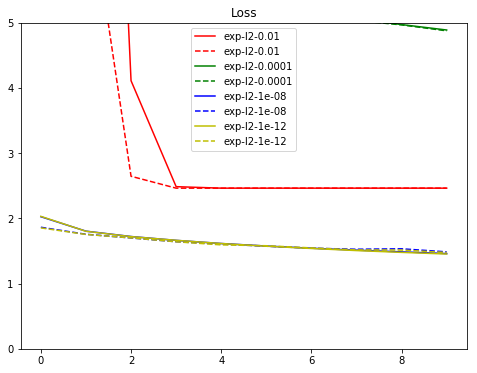

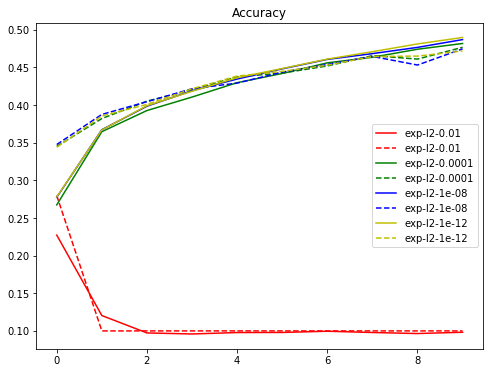

In [12]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1.keys()):
    plt.plot(range(len(results_l1[cond]['train-loss'])),results_l1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1[cond]['valid-loss'])),results_l1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1.keys()):
    plt.plot(range(len(results_l1[cond]['train-acc'])),results_l1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1[cond]['valid-acc'])),results_l1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

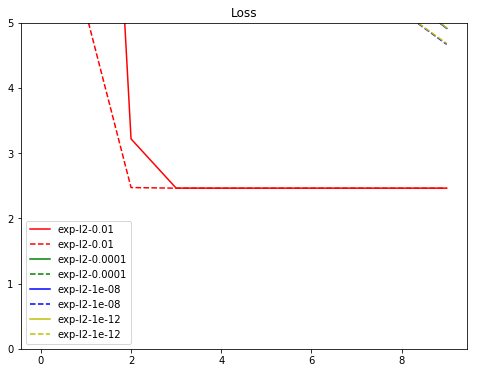

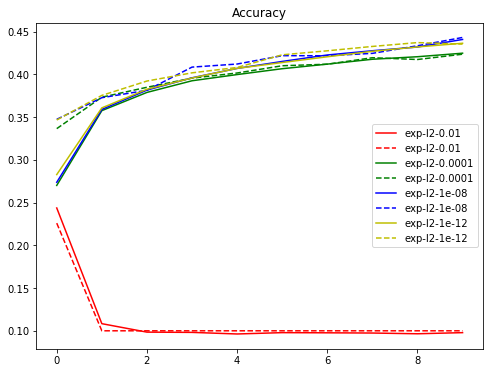

In [13]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1l2.keys()):
    plt.plot(range(len(results_l1l2[cond]['train-loss'])),results_l1l2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1l2[cond]['valid-loss'])),results_l1l2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_l1l2.keys()):
    plt.plot(range(len(results_l1l2[cond]['train-acc'])),results_l1l2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_l1l2[cond]['valid-acc'])),results_l1l2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()